<a href="https://colab.research.google.com/github/rhemish/ML_and_RL_Projects/blob/main/Telco%20Customer%20Churn%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn Prediction

**Date:** July 29, 2025

### **Problem Statement**

This project tackles customer churn prediction for a telecommunications company. The goal is to build classification models that identify which customers are most likely to leave the service based on their historical data.

**Assumptions**

I assumed the dataset was clean aside from a few formatting issues and that churn behavior could be inferred from transactional and service-related features.

**Constraints**

I worked within the constraint of using Python (Google Colab) with PyTorch, pandas, seaborn, and matplotlib. The dataset used was the Telco Customer Churn dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

#Loading the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
#Sum of null values per column
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
#Number of rows and columns
print("Shape of dataset:", df.shape)
#First 5 records
df.head()

Shape of dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Dataset statistics
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Data Preprocessing and Feature Engineering**

The dataset was preprocessed by converting the TotalCharges column to numeric and mapping the Churn column to binary labels (1 for churn, 0 for no churn). No missing values were imputed, rows with invalid TotalCharges were dropped.

Categorical features were transformed using a mix of label encoding (for binary columns) and one-hot encoding (for multiclass columns). Numerical features were standardized to improve model performance.

To enhance model learning, new features were engineered:

AvgMonthlyCharge = TotalCharges/tenure (captures long-term customer payment behavior)

ContractType and InternetType were derived from the Contract and InternetService columns to provide clearer segmentation.

The dataset was thoroughly explored using visualizations (histograms, scatter plots, correlation heatmaps, and churn distribution) to understand patterns and relationships.

Two models were trained and evaluated:

* A Feedforward Neural Network (NN)

* A Convolutional Neural Network (CNN)

Each was assessed using accuracy, precision, recall, F1-score, and ROC AUC, alongside confusion matrices and ROC curve plots for visual comparison.

In [ ]:
#Converting 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

#Converting churn labels to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df.drop('customerID', axis=1, inplace=True)

#Feature engineering: average monthly charge
df['AvgMonthlyCharge'] = df['TotalCharges'] / df['tenure']
df['AvgMonthlyCharge'] = df['AvgMonthlyCharge'].replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

#Contract types
df['ContractType'] = df['Contract'].map({
    'Month-to-month': 'Short',
    'One year': 'Medium',
    'Two year': 'Long'
})

#Internet types
df['InternetType'] = df['InternetService'].map({
    'DSL': 'Standard',
    'Fiber optic': 'Premium',
    'No': 'Basic'
})
print(df['Churn'].value_counts(normalize=True))

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


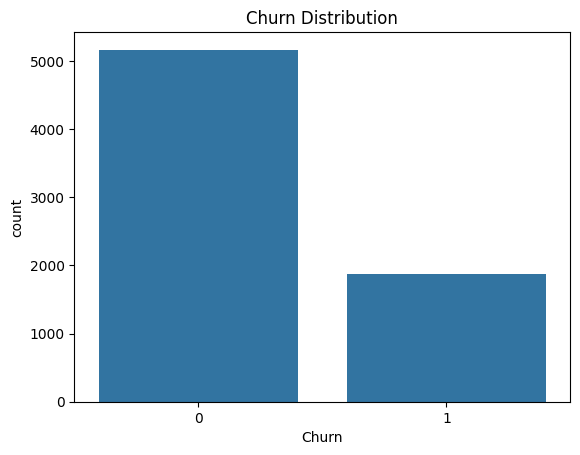

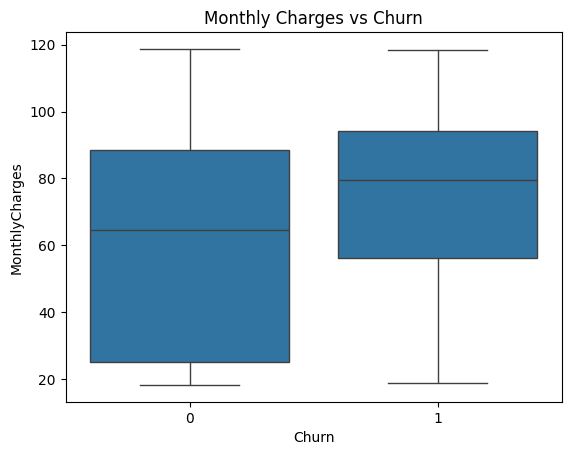

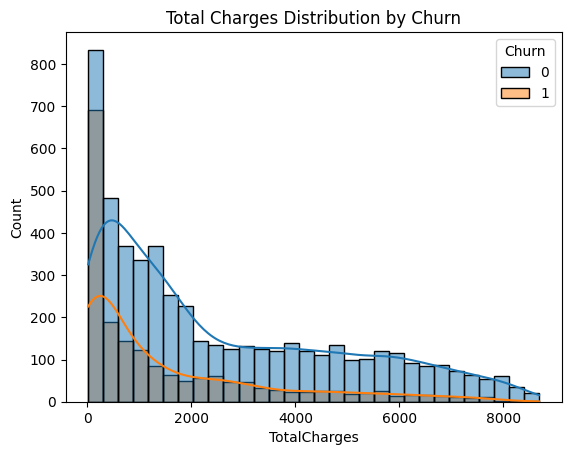

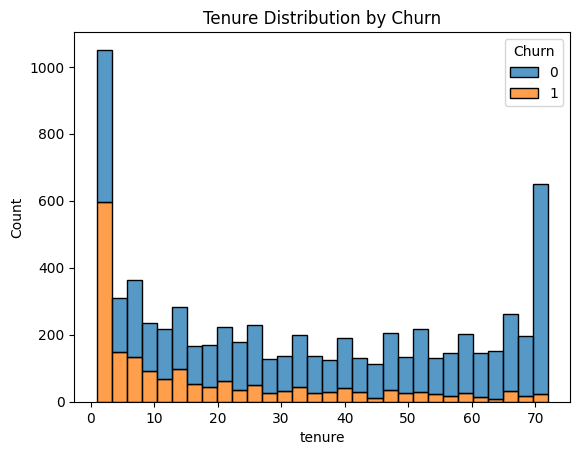

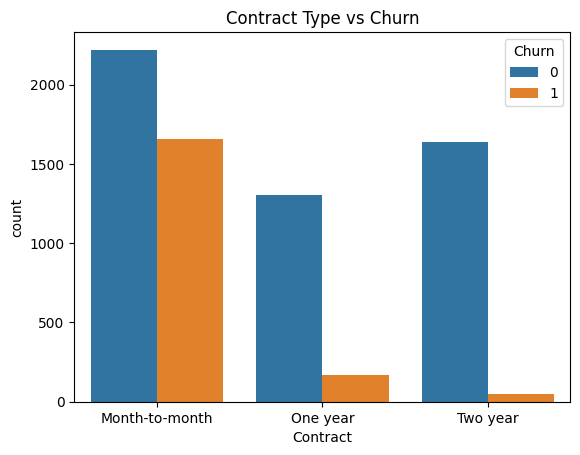

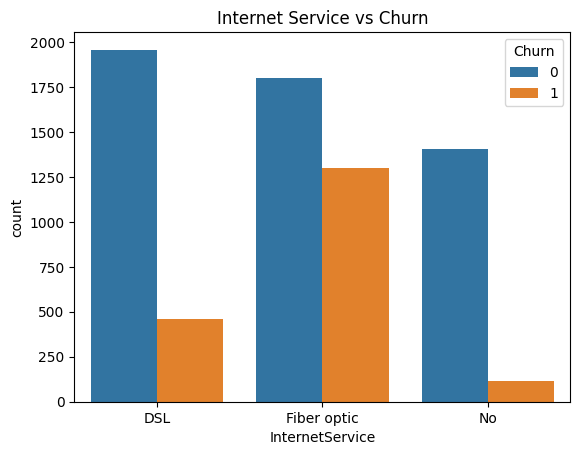

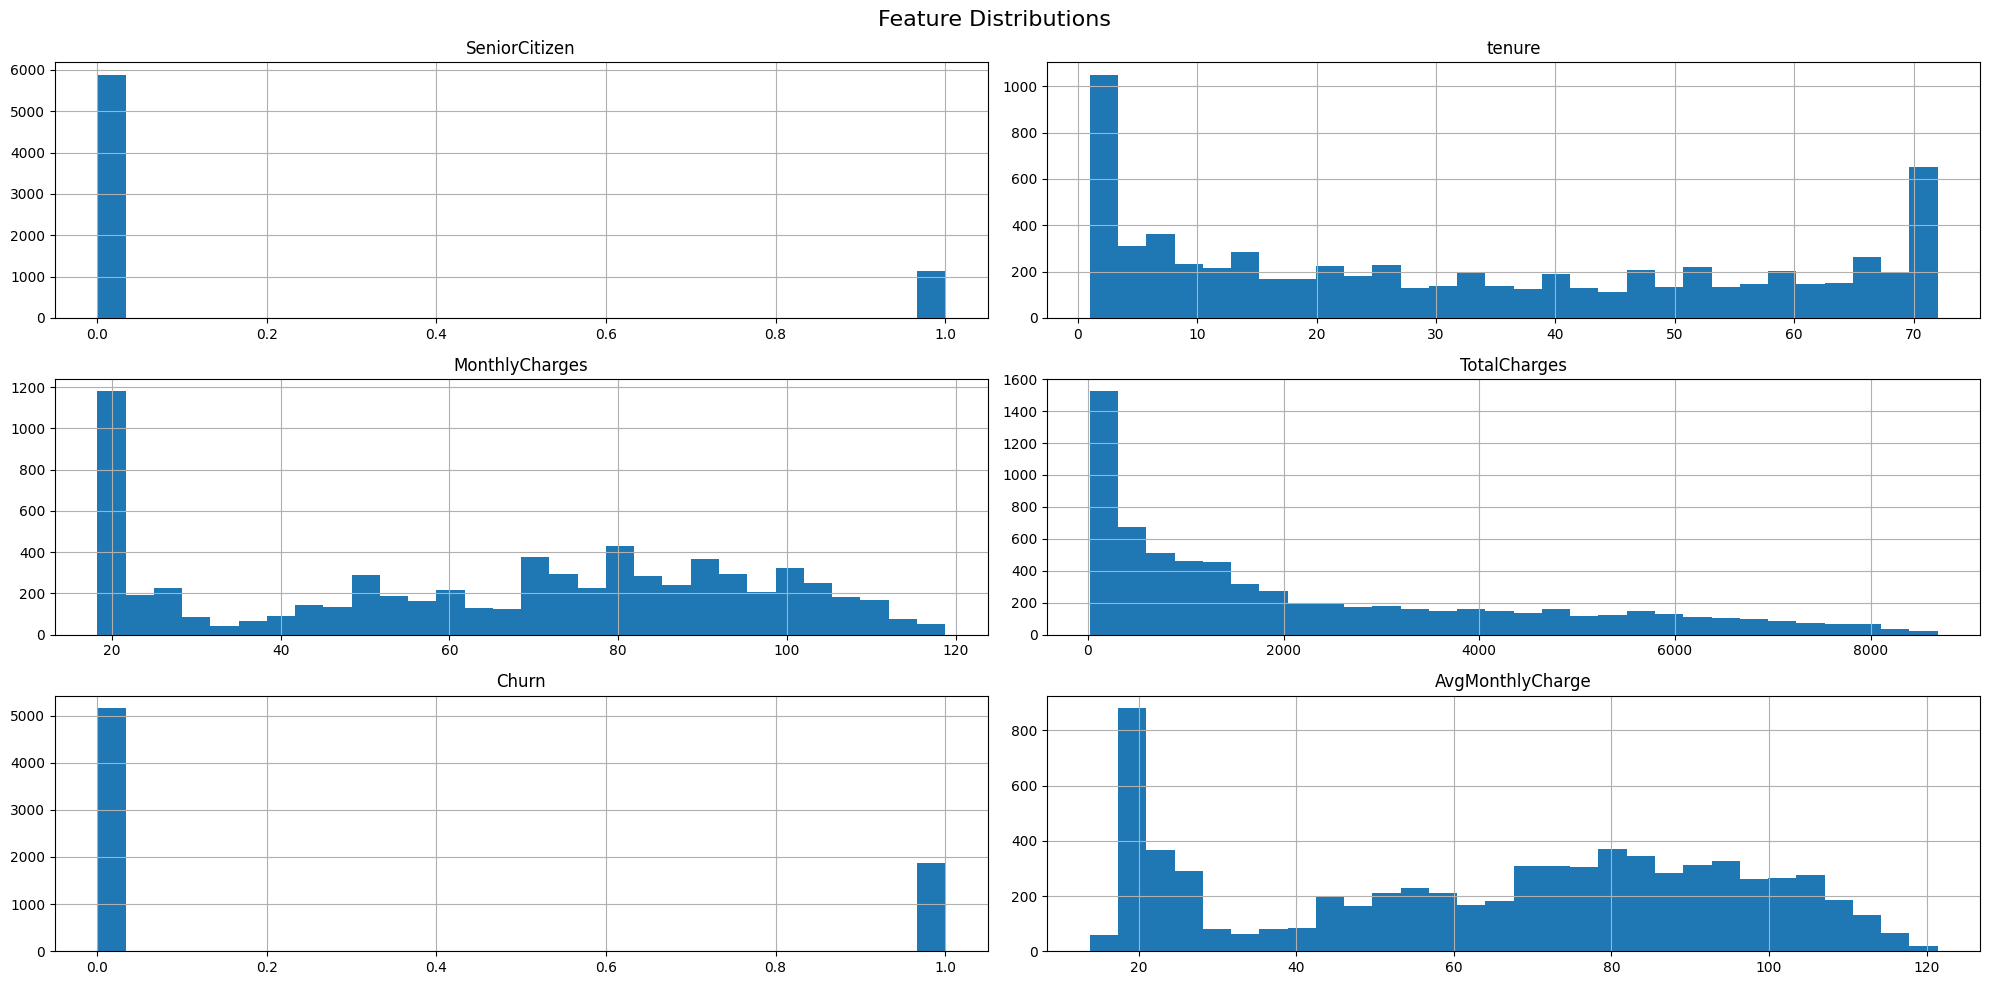

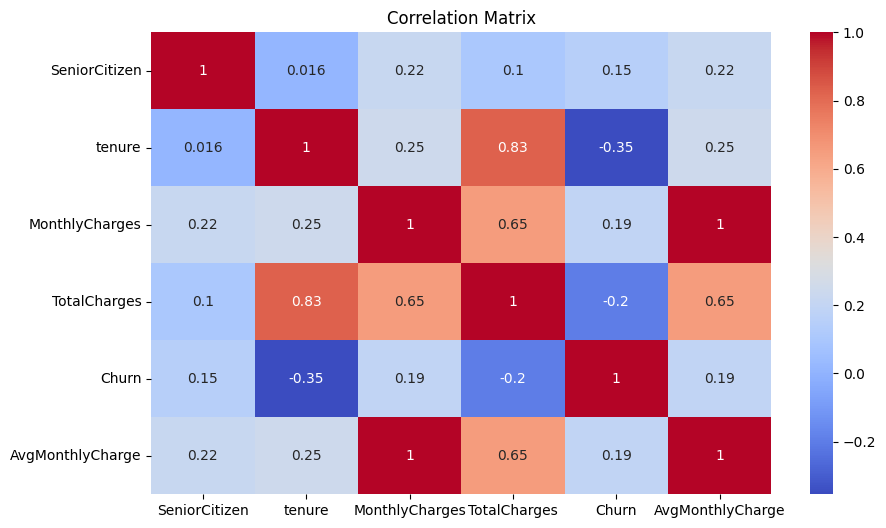

In [ ]:
#Churn distribution to check class imbalance
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

#Monthly charges between churned vs. retained customers
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges vs Churn')
plt.show()

#Total charges distribution
sns.histplot(data=df, x='TotalCharges', hue='Churn', kde=True, bins=30)
plt.title('Total Charges Distribution by Churn')
plt.show()

#Tenure distribution for churned vs. retained customers
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Tenure Distribution by Churn')
plt.show()

#Churn across contract types
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Contract Type vs Churn')
plt.show()

#Churn across internet types
sns.countplot(data=df, x='InternetService', hue='Churn')
plt.title('Internet Service vs Churn')
plt.show()

#Distribution of numerical features
df.hist(figsize=(20,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

#Correlation heatmap
plt.figure(figsize=(10, 6))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

* **Churn is imbalanced**, with ~27% of customers leaving.

* **Higher monthly charges** are linked to higher churn.

* Churned customers typically have **lower total charges** and **shorter tenure**.

* **Month-to-month contracts** show the highest churn rate.

* **Fiber optic users** churn more than DSL or no internet users.

* **Tenure** is negatively correlated with churn, confirming that long-term customers are more loyal.

In [ ]:
#Binary encoding
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == 'object']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

#One-hot encoding
df = pd.get_dummies(df, drop_first=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

#Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
#Converting data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

In [ ]:
#Defining neural network for binary classification
class ChurnNN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

#Defining CNN
class ChurnCNN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(16 * ((input_dim - 2) // 2), 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [ ]:
#Training the models
def train_model(model, train_loader, epochs=20, lr=0.001):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

input_dim = X_train.shape[1]

model_nn = ChurnNN(input_dim)
model_nn = train_model(model_nn, train_loader)

model_cnn = ChurnCNN(input_dim)
model_cnn = train_model(model_cnn, train_loader)

Epoch 1/20, Loss: 0.4084
Epoch 2/20, Loss: 0.4949
Epoch 3/20, Loss: 0.4541
Epoch 4/20, Loss: 0.4344
Epoch 5/20, Loss: 0.5136
Epoch 6/20, Loss: 0.5099
Epoch 7/20, Loss: 0.3650
Epoch 8/20, Loss: 0.4908
Epoch 9/20, Loss: 0.3963
Epoch 10/20, Loss: 0.4567
Epoch 11/20, Loss: 0.3858
Epoch 12/20, Loss: 0.4999
Epoch 13/20, Loss: 0.4750
Epoch 14/20, Loss: 0.3415
Epoch 15/20, Loss: 0.2856
Epoch 16/20, Loss: 0.4741
Epoch 17/20, Loss: 0.4004
Epoch 18/20, Loss: 0.4288
Epoch 19/20, Loss: 0.3332
Epoch 20/20, Loss: 0.3229
Epoch 1/20, Loss: 0.4187
Epoch 2/20, Loss: 0.2995
Epoch 3/20, Loss: 0.4470
Epoch 4/20, Loss: 0.4085
Epoch 5/20, Loss: 0.3171
Epoch 6/20, Loss: 0.5709
Epoch 7/20, Loss: 0.4827
Epoch 8/20, Loss: 0.4947
Epoch 9/20, Loss: 0.4549
Epoch 10/20, Loss: 0.4697
Epoch 11/20, Loss: 0.4746
Epoch 12/20, Loss: 0.4764
Epoch 13/20, Loss: 0.4600
Epoch 14/20, Loss: 0.3977
Epoch 15/20, Loss: 0.3248
Epoch 16/20, Loss: 0.3400
Epoch 17/20, Loss: 0.3312
Epoch 18/20, Loss: 0.3374
Epoch 19/20, Loss: 0.2879
Epoc

In [ ]:
def evaluate_model(model, X_test_tensor, y_test):
    model.eval()
    with torch.no_grad():
        y_prob = model(X_test_tensor).numpy()
    y_pred = (y_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)
    print("ROC AUC Score:", auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    return fpr, tpr, auc, acc



Neural Network Evaluation 
Accuracy: 0.7874911158493249
Precision: 0.60932944606414
Recall: 0.5588235294117647
F1-score: 0.5829846582984658
ROC AUC Score: 0.8286052254220353

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.61      0.56      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



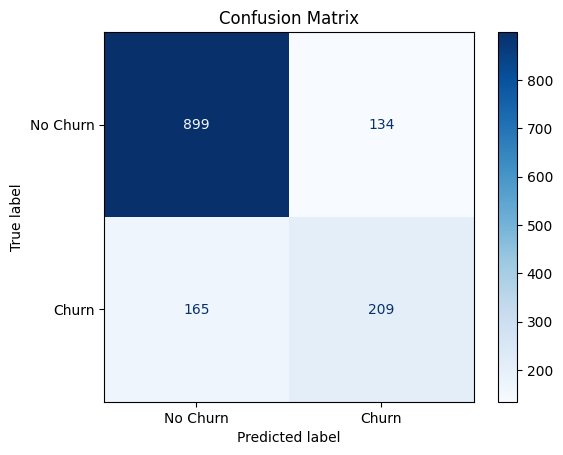


Convolutional Neural Network Evaluation 
Accuracy: 0.7882018479033405
Precision: 0.6130952380952381
Recall: 0.5508021390374331
F1-score: 0.5802816901408451
ROC AUC Score: 0.8285016902122989

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.61      0.55      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



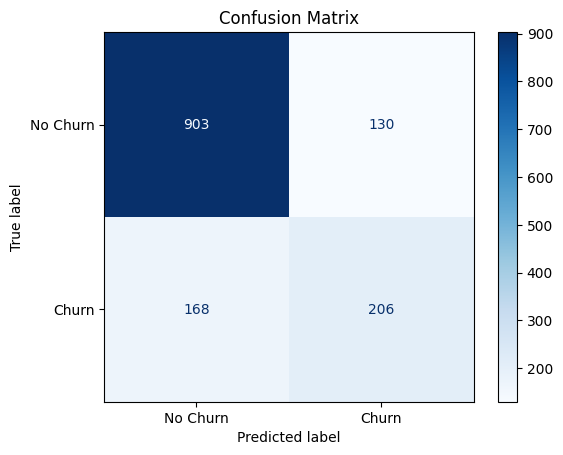

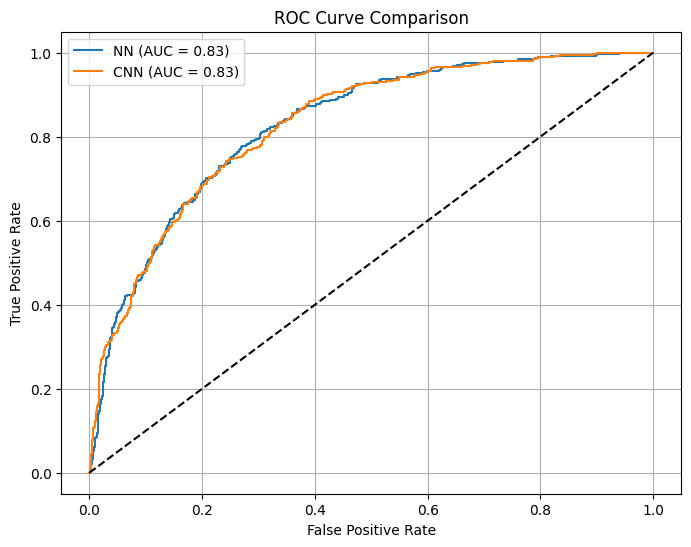

Accuracy (NN):  0.7875
Accuracy (CNN): 0.7882


In [ ]:
#Evaluating both models
print("\nNeural Network Evaluation ")
fpr_nn, tpr_nn, auc_nn, acc_nn = evaluate_model(model_nn, X_test_tensor, y_test)

print("\nConvolutional Neural Network Evaluation ")
fpr_cnn, tpr_cnn, auc_cnn, acc_cnn = evaluate_model(model_cnn, X_test_tensor, y_test)

#ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC = {auc_nn:.2f})')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

#Accuracy comparison
print(f"Accuracy (NN):  {acc_nn:.4f}")
print(f"Accuracy (CNN): {acc_cnn:.4f}")


**Model Results and Key Findings**

Both the Neural Network (NN) and Convolutional Neural Network (CNN) models performed similarly on the churn prediction task, with comparable accuracy (Approximately 78%) and nearly identical ROC-AUC scores (~0.83). The NN very slightly outperformed the CNN in recall and AUC, making it the better option if minimizing false negatives is a priority.

Despite using a CNN architecture, no significant improvement was observed, which is expected in a tabular data context where CNNs offer little advantage. Feedforward NNs are more suited to structured datasets like this one, offering simplicity and interpretability without sacrificing performance.

However, both models showed weaker performance on the minority class (churners), signaling that churn remains harder to detect. Class imbalance was partially handled, but metrics like recall and F1-score for churn could benefit from further tuning, such as oversampling, undersampling, or applying class weights during training.

**Feature Impact**

EDA revealed several features strongly associated with churn:

* Customers with month-to-month contracts, higher monthly charges, and short tenure showed significantly higher churn rates.

* Those using fiber optic internet were more likely to churn than DSL users.

* TotalCharges and tenure were positively correlated, suggesting long-term customers generate higher lifetime value and are less likely to churn.

**Retention Recommendations:**

* Incentivize longer-term contracts through discounts or bundled offers.

* Identify high-risk new customers early and offer loyalty perks before tenure crosses 3–6 months.

* Monitor customers with high monthly charges and fiber connections as they may be cost-sensitive or dissatisfied with service quality.